# Training a Model

The following notebook outlines how to train a binary model in the cohesive vs. non-cohesive case (which with a few modifications can be changed to the non-free flowing vs. free flowing or the multiclass case).

The first thing to do is to import the relevant libraries.

In [1]:
%matplotlib notebook
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from data_prep import training_data_prep
from model import vgg11
from training import BinaryTrainer

/home/gwb21218/miniconda3/envs/dm2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gwb21218/miniconda3/envs/dm2/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


Next the path to the images and the class labels are defined.

In [2]:
image_path = "../20220929_dataset_all_classes/"
labels_path = "../20220929_dataset_all_classes/FFc_data_with_G3descs.txt"

Now we use the `training_data_prep` function to segment and augment the dataset and return the training and validation data along with their ground truth labels. This function takes inputs:

* `imgs_pth` &mdash; the path to the images, in this case `image_path`
* `class_pth` &mdash; the path to the file containing the class labels, in this case `labels_path`
* `model_classes` &mdash; which model is being trained to tell the code which numerical label to assign to each image, here is `"cohesive"` which is the cohesive vs. non-cohesive model

This function reads in all the images and augments them will a vertical and horizontal mirroring before splitting them up into 1024$\times$1024 segments which are used for the training and validation.

The outputs are:

* 

In [3]:
trainval_images, trainval_labels = training_data_prep(image_path, labels_path, model_classes="cohesive")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [16:56<00:00,  3.77s/it]


In [4]:
indices = np.arange(trainval_labels.shape[0])
np.random.RandomState(seed=12).shuffle(indices)
max_idx = int(0.9*indices.shape[0])

train_in = torch.from_numpy(trainval_images[indices[:max_idx]]).unsqueeze(1)
train_out = torch.from_numpy(trainval_labels[indices[:max_idx]])
val_in = torch.from_numpy(trainval_images[indices[max_idx:]]).unsqueeze(1)
val_out = torch.from_numpy(trainval_labels[indices[max_idx:]])

In [5]:
vgg = vgg11(model_type="binary")

In [6]:
optimi = optim.SGD(vgg.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
sched = optim.lr_scheduler.ReduceLROnPlateau(optimi, factor=0.1, patience=2, verbose=True)

In [7]:
_, counts = np.unique(train_out, return_counts=True)

In [8]:
pos_weight = torch.tensor(counts[0]/counts[1]).to("cuda:0")
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [9]:
trainer = BinaryTrainer(
    model = vgg, optimiser = optimi, loss_fn = loss_fn, no_of_epochs=50, batch_size=24, data_pth=None, save_dir="vgg11_co_230123/", scheduler=sched, device_id=0
)

In [10]:
trainer.load_data(train_in, train_out, val_in, val_out)

In [13]:
loss_fn

BCEWithLogitsLoss()

<IPython.core.display.Javascript object>


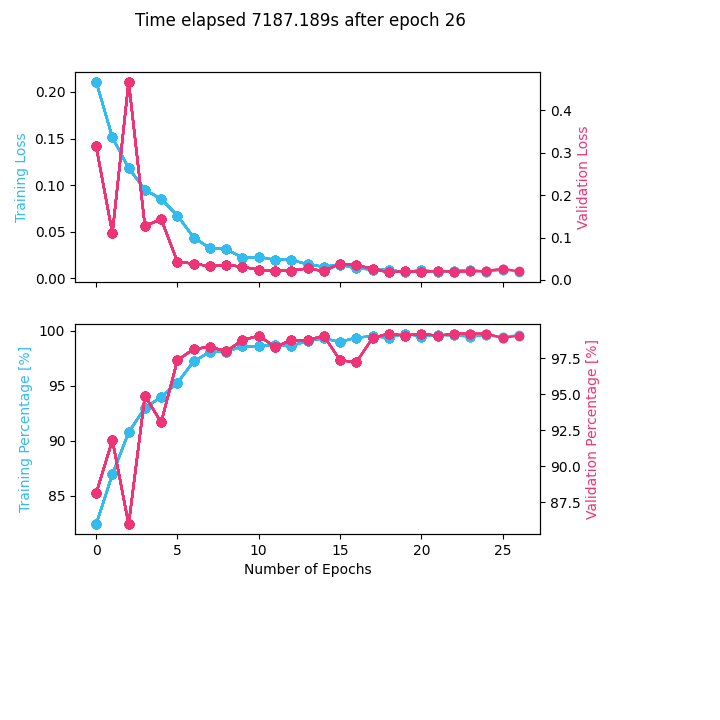

  0%|                                                                                                                                                                                      | 0/243 [00:00<?, ?it/s]/home/gwb21218/miniconda3/envs/dm2/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [04:15<00:00,  1.05s/it]


Epoch 00005: reducing learning rate of group 0 to 1.0000e-03.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [04:15<00:00,  1.05s/it]


Epoch 00018: reducing learning rate of group 0 to 1.0000e-04.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [04:15<00:00,  1.05s/it]


Epoch 00022: reducing learning rate of group 0 to 1.0000e-05.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [04:15<00:00,  1.05s/it]


Epoch 00025: reducing learning rate of group 0 to 1.0000e-06.


 23%|████████████████████████████████████████▌                                                                                                                                    | 57/243 [00:59<03:15,  1.05s/it]

In [ ]:
trainer.shady_guy()